In [2]:
# pip install numpy matplotlib quantecon gymnasium networkx

In [3]:
import numpy as np

import quantecon as qe
import gymnasium as gym
import networkx as nx

import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 1. Discrete Markov Chain

## 1.1 Visualization

### Example from [[QuantEcon lecture](https://python.quantecon.org/finite_markov.html)]

Imam and Temple [[Imam and Temple, 2023](https://intro.quantecon.org/zreferences.html#id289)] categorize political institutions into
three types: democracy $ \text{(D)} $, autocracy $ \text{(A)} $, and an intermediate
state called anocracy $ \text{(N)} $.

Each institution can have two potential development regimes: collapse $ \text{(C)} $ and growth $ \text{(G)} $. This results in six possible states: $ \text{DG, DC, NG, NC, AG} $ and $ \text{AC} $.

Imam and Temple [[Imam and Temple, 2023](https://intro.quantecon.org/zreferences.html#id289)] estimate the following transition
probabilities:

$$
P :=
\begin{bmatrix}
0.86 & 0.11 & 0.03 & 0.00 & 0.00 & 0.00 \\
0.52 & 0.33 & 0.13 & 0.02 & 0.00 & 0.00 \\
0.12 & 0.03 & 0.70 & 0.11 & 0.03 & 0.01 \\
0.13 & 0.02 & 0.35 & 0.36 & 0.10 & 0.04 \\
0.00 & 0.00 & 0.09 & 0.11 & 0.55 & 0.25 \\
0.00 & 0.00 & 0.09 & 0.15 & 0.26 & 0.50
\end{bmatrix}
$$

In [4]:
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']
P = [[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
     [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
     [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
     [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
     [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
     [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]]

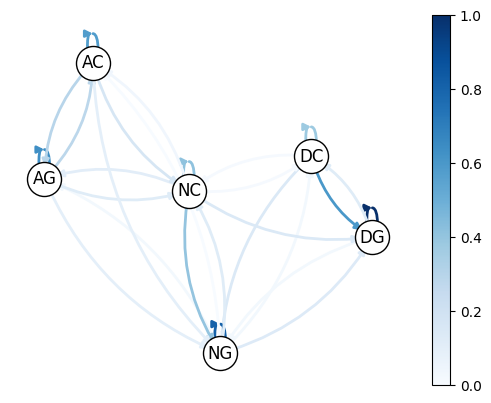

In [5]:
G = nx.MultiDiGraph()

for start_idx, node_start in enumerate(nodes):
    for end_idx, node_end in enumerate(nodes):
        value = P[start_idx][end_idx]
        if value != 0:
            G.add_edge(node_start,node_end, weight=value)

pos = nx.spring_layout(G, seed=10)
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, node_size=600, edgecolors='black', node_color='white')
nx.draw_networkx_labels(G, pos)

arc_rad = 0.2

edges = nx.draw_networkx_edges(G, pos, ax=ax, connectionstyle=f'arc3, rad = {arc_rad}', edge_cmap=cm.Blues, width=2,
    edge_color=[G[nodes[0]][nodes[1]][0]['weight'] for nodes in G.edges])

pc = mpl.collections.PatchCollection(edges, cmap=cm.Blues)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

## 1.2 Simulation

To simulate a Markov chain, we need

1. a stochastic matrix $ P $ and  
1. a probability mass function $ \psi_0 $ of length $ n $ from which to draw an initial realization of $ X_0 $.  

We’ll write our code as a function that accepts the following three arguments

- A stochastic matrix `P`.  
- An initial distribution `ψ_0`.  
- A positive integer `ts_length` representing the length of the time series the function should return.  

In [8]:
ψ_0 = (0.3, 0.7)           # probabilities over {0, 1}
cdf = np.cumsum(ψ_0)       # convert into cumulative distribution
qe.random.draw(cdf, 5)   # generate 5 independent draws from ψ

array([1, 1, 1, 1, 0])

In [12]:
def mc_sample_path(P, ψ_0=None, ts_length=1_000):

    # set up
    P = np.asarray(P)
    X = np.empty(ts_length, dtype=int)

    # Convert each row of P into a cdf
    P_dist = np.cumsum(P, axis=1)  # Convert rows into cdfs

    # draw initial state, defaulting to 0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0

    # simulate
    X[0] = X_0
    for t in range(ts_length - 1):
        X[t+1] = qe.random.draw(P_dist[X[t], :])

    return X

In [22]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

# example to show the dimension of P and ψ_0 does not necessarily match

# P = [[0.2, 0.6, 0.2],
#      [0.2, 0.2, 0.6],
#      [0.5, 0.3, 0.2]]

# example to show non-irreducibility

# P = [[0.5, 0.5, 0.0],
#      [0.4, 0.6, 0.0],
#      [0.5, 0.3, 0.2]]

mc_sample_path(P, ψ_0=(1.0, 0.0), ts_length=10)

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [23]:
# example to show ergodicity

X = mc_sample_path(P, ψ_0=(0.1, 0.9), ts_length=1_000_000)
np.mean(X == 0)

np.float64(0.249608)

### Using QuantEcon’s routines

In [24]:
mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

np.float64(0.249793)

In [25]:
%time mc_sample_path(P, ts_length=1_000_000) # Our homemade code version

CPU times: user 401 ms, sys: 3.79 ms, total: 405 ms
Wall time: 404 ms


array([0, 1, 1, ..., 1, 1, 1], shape=(1000000,))

In [26]:
%time mc.simulate(ts_length=1_000_000) # qe code version

CPU times: user 19.8 ms, sys: 2.87 ms, total: 22.7 ms
Wall time: 21.3 ms


array([0, 0, 1, ..., 1, 0, 0], shape=(1000000,))

In [27]:
mc = qe.MarkovChain(P, state_values=('unemployed', 'employed'))
mc.simulate(ts_length=4, init='employed')  # Start at employed initial state

array(['employed', 'unemployed', 'employed', 'employed'], dtype='<U10')

In [29]:
mc.simulate(ts_length=4)  # Start at randomly chosen initial state

array(['unemployed', 'employed', 'employed', 'employed'], dtype='<U10')

In [30]:
mc.simulate_indices(ts_length=4)

array([1, 1, 1, 1])

## 1.3 Stationary Distribution

In [31]:
P = np.array([[0.4, 0.6],
              [0.2, 0.8]])
ψ = (0.25, 0.75)
ψ @ P

array([0.25, 0.75])

In [32]:
P = np.array([[0.5, 0.5],
              [0.5, 0.5]])
ψ = (0.5, 0.5)
ψ @ P

array([0.5, 0.5])

Formally, a distribution $ \psi^* $ on $ S $ is called **stationary** for $ P $ if $ \psi^* P = \psi^* $.


In [ ]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
mc.stationary_distributions
# Show all stationary distributions

array([[0.25, 0.75]])

#### Example: Hamilton’s chain

In [34]:
P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])

mc = qe.MarkovChain(P)
mc.stationary_distributions

array([[0.8128 , 0.16256, 0.02464]])

In [35]:
def iterate_ψ(ψ_0, P, ts_length):
    n = len(P)
    ψ_t = np.empty((ts_length, n))
    ψ_t[0]= ψ_0
    for t in range(1, ts_length):
        ψ_t[t] = ψ_t[t-1] @ P
    return ψ_t

In [36]:
ψ_1 = (0.0, 0.0, 1.0)
ψ_2 = (1.0, 0.0, 0.0)
ψ_3 = (0.0, 1.0, 0.0)                   # Three initial conditions
colors = ['blue','red', 'green']   # Different colors for each initial point

# Define the vertices of the unit simplex
v = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]])

# Define the faces of the unit simplex
faces = [
    [v[0], v[1], v[2]],
    [v[0], v[1], v[3]],
    [v[0], v[2], v[3]],
    [v[1], v[2], v[3]]
]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def update(n):    
    ax.clear()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.view_init(45, 45)
    
    simplex = Poly3DCollection(faces, alpha=0.03)
    ax.add_collection3d(simplex)
    
    for idx, ψ_0 in enumerate([ψ_1, ψ_2, ψ_3]):
        ψ_t = iterate_ψ(ψ_0, P, n+1)
        
        for i, point in enumerate(ψ_t):
            ax.scatter(point[0], point[1], point[2], color=colors[idx], s=60, alpha=(i+1)/len(ψ_t))
            
    mc = qe.MarkovChain(P)
    ψ_star = mc.stationary_distributions[0]
    ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='yellow', s=60)
    
    return fig,

anim = FuncAnimation(fig, update, frames=range(20), blit=False, repeat=False)
plt.close()
HTML(anim.to_jshtml())

# 2. AR(1) Process

## 2.1 Characterization

The **AR(1) model** (autoregressive model of order 1) takes the form


<a id='equation-can-ar1'></a>
$$
X_{t+1} = a X_t + b + c W_{t+1}
$$

### Moving average representation

Iterating backwards from time $ t $, we obtain

$$
X_t = a X_{t-1} + b +  c W_t
        = a^2 X_{t-2} + a b + a c W_{t-1} + b + c W_t
        = a^3 X_{t-3} + a^2 b + a^2 c W_{t-2} + b + c W_t
        = \cdots
$$

If we work all the way back to time zero, we get


<a id='equation-ar1-ma'></a>
$$
X_t = a^t X_0 + b \sum_{j=0}^{t-1} a^j +
        c \sum_{j=0}^{t-1} a^j  W_{t-j}
$$

It shows that $ X_t $ is a well defined random variable, the value of which depends on

- the parameters,  
- the initial condition $ X_0 $ and  
- the shocks $ W_1, \ldots W_t $ from time $ t=1 $ to the present.  


Throughout, the symbol $ \psi_t $ will be used to refer to the
density of this random variable $ X_t $.

Given that $ X_t $ is normally distributed, we will know the full distribution
$ \psi_t $ if we can pin down its first two moments.

Let $ \mu_t $ and $ v_t $ denote the mean and variance of $ X_t $ respectively.

We can use the following
recursive expressions:


<a id='equation-dyn-tm'></a>
$$
\mu_{t+1} = a \mu_t + b
\quad \text{and} \quad
v_{t+1} = a^2 v_t + c^2
$$

## 2.2 Stationary Distribution


In [37]:
a, b, c = 0.9, 0.1, 0.5

mu, v = -3.0, 0.6  # initial conditions mu_0, v_0

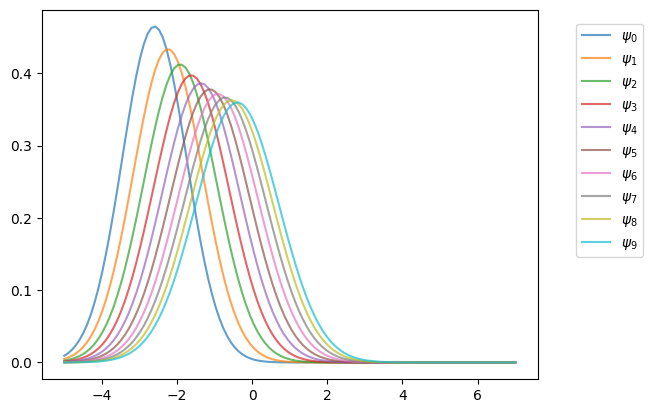

In [38]:
from scipy.stats import norm

sim_length = 10
grid = np.linspace(-5, 7, 120)

fig, ax = plt.subplots()

for t in range(sim_length):
    mu = a * mu + b
    v = a**2 * v + c**2
    ax.plot(grid, norm.pdf(grid, loc=mu, scale=np.sqrt(v)),
            label=fr"$\psi_{t}$",
            alpha=0.7)

ax.legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=1)

plt.show()

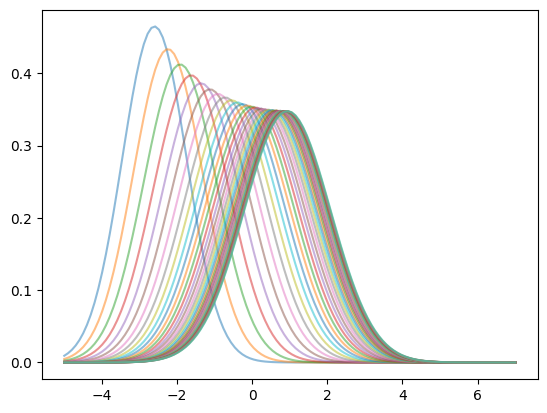

In [40]:
def plot_density_seq(ax, mu_0=-3.0, v_0=0.6, sim_length=40):
    mu, v = mu_0, v_0
    for t in range(sim_length):
        mu = a * mu + b
        v = a**2 * v + c**2
        ax.plot(grid,
                norm.pdf(grid, loc=mu, scale=np.sqrt(v)),
                alpha=0.5)
    
fig, ax = plt.subplots()
plot_density_seq(ax)
plt.show()

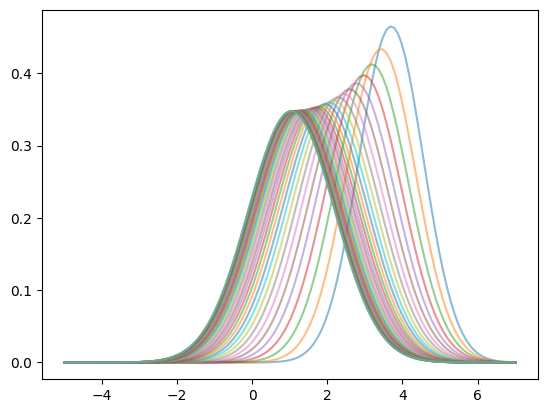

In [128]:
fig, ax = plt.subplots()
plot_density_seq(ax, mu_0=4.0)
plt.show()

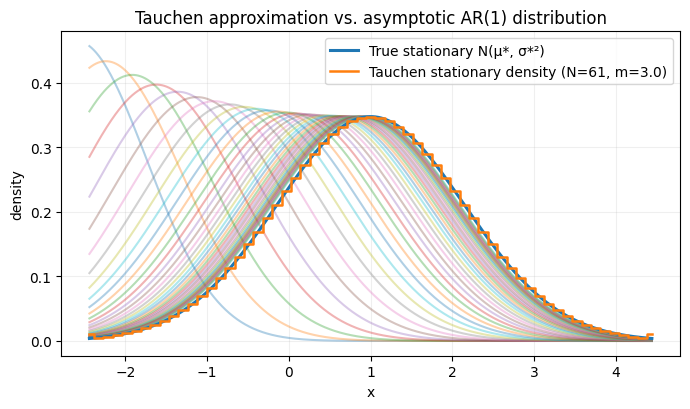

In [41]:
from math import erf

a, b, c = 0.9, 0.1, 0.5       # X_{t+1} = a X_t + b + c * W_{t+1},  W ~ N(0,1)
mu0, v0 = -3.0, 0.6           # initial mean/variance

# ---- Stationary (asymptotic) distribution of the AR(1) ----
assert abs(a) < 1, "Stationary dist requires |a|<1."
mu_star = b / (1 - a)
v_star  = c**2 / (1 - a**2)
sig_star = np.sqrt(v_star)

# ---- Tauchen discretization for this AR(1) ----
def tauchen_ar1(N=41, m=3.0):
    """
    Tauchen (1986) for X_{t+1} = a * X_t + b + c * W_{t+1}, W ~ N(0,1)
    Returns:
      z : (N,) grid
      P : (N,N) transition matrix
    """
    # grid centered at stationary mean, spanning +/- m * stationary std
    zmin, zmax = mu_star - m*sig_star, mu_star + m*sig_star
    z = np.linspace(zmin, zmax, N)
    step = z[1] - z[0]

    # standard normal CDF helper
    def Phi(x): return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))

    P = np.zeros((N, N))
    for i in range(N):
        mu_cond = a * z[i] + b         # E[X_{t+1} | X_t = z_i]
        sd = c                          # std of innovation
        for j in range(N):
            if j == 0:
                a_int = -np.inf
                b_int = (z[0] - mu_cond + 0.5*step) / sd
            elif j == N - 1:
                a_int = (z[-1] - mu_cond - 0.5*step) / sd
                b_int = np.inf
            else:
                a_int = (z[j] - mu_cond - 0.5*step) / sd
                b_int = (z[j] - mu_cond + 0.5*step) / sd
            P[i, j] = Phi(b_int) - Phi(a_int)

        # numerical tidy
        rowsum = P[i].sum()
        if rowsum > 0:
            P[i] /= rowsum
        else:
            # extremely unlikely, fallback to nearest mass
            P[i, np.argmin(np.abs(z - mu_cond))] = 1.0
    return z, P

# ---- Stationary distribution of the discrete Markov chain ----
def stationary_dist(P, tol=1e-14, maxit=1_000_000):
    # power method on a row-stochastic P to get left eigenvector
    N = P.shape[0]
    pi = np.ones(N) / N
    for _ in range(maxit):
        new = pi @ P
        if np.max(np.abs(new - pi)) < tol:
            return new
        pi = new
    return pi

# ---- Plot sequence of Gaussian densities N(mu_t, v_t) ----
def plot_density_seq(ax, grid, mu_0=mu0, v_0=v0, sim_length=40, alpha=0.35):
    mu, v = mu_0, v_0
    for _ in range(sim_length):
        mu = a * mu + b
        v  = a**2 * v + c**2
        ax.plot(grid, norm.pdf(grid, loc=mu, scale=np.sqrt(v)), lw=1.5, alpha=alpha, label=None)

# ---- Build Tauchen, its stationary density, and plot everything ----
N, m = 61, 3.0
z, P = tauchen_ar1(N=N, m=m)
pi = stationary_dist(P)

# turn the discrete stationary probabilities into a piecewise-constant density
dz = z[1] - z[0]
tauchen_density = pi / dz   # so that integral ≈ sum(pi) = 1

# a fine grid for smooth Gaussian plots
x = np.linspace(mu_star - m*sig_star, mu_star + m*sig_star, 1000)

fig, ax = plt.subplots(figsize=(7, 4.2))

# sequence of Gaussians (convergence over t)
plot_density_seq(ax, x, mu_0=mu0, v_0=v0, sim_length=40, alpha=0.35)

# true stationary Gaussian
ax.plot(x, norm.pdf(x, loc=mu_star, scale=sig_star), lw=2.2, label="True stationary N(μ*, σ*²)")

# Tauchen stationary density (bars / step)
ax.step(z, tauchen_density, where="mid", lw=1.8, label="Tauchen stationary density (N={}, m={})".format(N, m))

ax.set_title("Tauchen approximation vs. asymptotic AR(1) distribution")
ax.set_xlabel("x")
ax.set_ylabel("density")
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 3. Reinforcement Learning Environment

In [ ]:
env = gym.make("CartPole-v1")         # observation: Box(4,), action: Discrete(2
)
# env = gym.make("Pendulum-v1")
print(env.spec.max_episode_steps)
obs, info = env.reset(seed=0)
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()               # random policy
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"obs: {obs}, reward: {reward}, terminated: {terminated}, truncated: {truncated}")
    total_reward += reward
    done = terminated or truncated

env.close()
print("CartPole total reward:", total_reward)

500
obs: [ 0.01323574  0.17272775 -0.04686959 -0.3551522 ], reward: 1.0, terminated: False, truncated: False
obs: [ 0.0166903  -0.02169755 -0.05397264 -0.07760915], reward: 1.0, terminated: False, truncated: False
obs: [ 0.01625635 -0.21600589 -0.05552482  0.1975687 ], reward: 1.0, terminated: False, truncated: False
obs: [ 0.01193623 -0.4102915  -0.05157344  0.47223207], reward: 1.0, terminated: False, truncated: False
obs: [ 0.0037304  -0.60464853 -0.04212881  0.74822414], reward: 1.0, terminated: False, truncated: False
obs: [-0.00836257 -0.7991648  -0.02716432  1.0273575 ], reward: 1.0, terminated: False, truncated: False
obs: [-0.02434587 -0.9939148  -0.00661717  1.3113893 ], reward: 1.0, terminated: False, truncated: False
obs: [-0.04422417 -0.7987097   0.01961061  1.0166427 ], reward: 1.0, terminated: False, truncated: False
obs: [-0.06019836 -0.9940875   0.03994347  1.3154182 ], reward: 1.0, terminated: False, truncated: False
obs: [-0.08008011 -1.1896915   0.06625183  1.620330

In [43]:
from gymnasium import spaces

class MiniGrid3x3:
    """Simplest 3×3 Gridworld"""
    def __init__(self):
        self.size = 3
        self.start = (0, 0)
        self.goal = (2, 2)
        self.action_space = spaces.Discrete(4)           # 0:Up  1:Down  2:Left  3:Right
        self.observation_space = spaces.Discrete(self.size * self.size)
        self.max_steps = 30

    def _encode(self, pos):
        r, c = pos
        return r * self.size + c

    def reset(self):
        self.pos = self.start
        self.steps = 0
        return self._encode(self.pos), {}

    def step(self, action):
        r, c = self.pos
        if action == 0 and r > 0: r -= 1
        elif action == 1 and r < self.size - 1: r += 1
        elif action == 2 and c > 0: c -= 1
        elif action == 3 and c < self.size - 1: c += 1
        self.pos = (r, c)
        self.steps += 1

        terminated = (self.pos == self.goal)
        truncated = (self.steps >= self.max_steps)
        reward = 0 if terminated else -1.0
        return self._encode(self.pos), reward, terminated, truncated, {}

    def render(self):
        grid = np.full((self.size, self.size), '.', dtype=str)
        gr, gc = self.goal
        grid[gr, gc] = 'G'
        r, c = self.pos
        grid[r, c] = 'A'
        print("\n".join(" ".join(row) for row in grid))
        print()

In [44]:
env = MiniGrid3x3()
obs, info = env.reset()
done = False
total_reward = 0

while not done:
    env.render()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated

print("Total reward:", total_reward)
env.render()          # final state

A . .
. . .
. . G

. . .
A . .
. . G

A . .
. . .
. . G

. . .
A . .
. . G

A . .
. . .
. . G

A . .
. . .
. . G

A . .
. . .
. . G

A . .
. . .
. . G

. A .
. . .
. . G

. A .
. . .
. . G

. A .
. . .
. . G

. A .
. . .
. . G

. A .
. . .
. . G

. . A
. . .
. . G

. . A
. . .
. . G

. . .
. . A
. . G

Total reward: -15.0
. . .
. . .
. . A

